#### What is Parallelization in LangGraph?
In LangGraph, nodes typically execute in a sequence defined by edges, but when tasks don’t depend on each other’s outputs, you can run them in parallel. This is achieved by:
- Defining multiple nodes that can operate independently.

- Connecting them to a common starting point (e.g., START or another node).

- Merging their outputs into a downstream node if needed.

LangGraph handles this implicitly when nodes are independent and can leverage multi-threading or asynchronous execution under the hood, depending on the runtime environment (e.g., Python’s asyncio or a multi-threaded executor).

![image.png](attachment:image.png)

In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

llm=ChatGroq(model="qwen/qwen3-32b")

In [3]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# Graph state
class State(TypedDict):
    topic: str
    characters: str
    settings: str
    premises: str
    story_intro: str

In [9]:
# Nodes

def generate_characters(state:State):
    """Generate Character Description"""
    msg = llm.invoke(f"Create two character names and brief traits for a story about {state["topic"]}")
    return {"characters":msg.content}

def generate_settings(state:State):
    """Generate a story Setting"""
    msg = llm.invoke(f"Describe a vivid setting for a story about{state["topic"]}")
    return {"settings":msg.content}

def generate_premise(state:State):
    """Generate a story premises"""
    msg = llm.invoke(f"write a one-sentence plot premise for a story about {state["topic"]}")
    return {"premises":msg.content}


def combine_elements(state:State):
    """Combine characters, setting, and premise into an intro"""
    msg = llm.invoke(
        f"Write a short story introduction using these elements:\n"
        f"Characters:{state["characters"]}\n"
        f"settings :{state["settings"]}\n"
        f"premises:{state["premises"]}"
    )
    return {"story_intro":msg.content}

In [10]:
# Build the graph
graph = StateGraph(State)
graph.add_node("characters",generate_characters)
graph.add_node("settings",generate_settings)
graph.add_node("premises",generate_premise)
graph.add_node("combine",combine_elements)

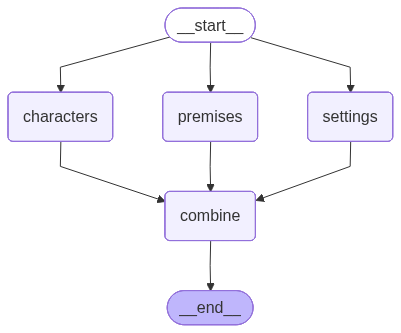

In [11]:
# Define edges (parallel execution from START)

graph.add_edge(START,"characters")
graph.add_edge(START,"settings")
graph.add_edge(START,"premises")
graph.add_edge("characters","combine")
graph.add_edge("settings","combine")
graph.add_edge("premises","combine")

#compiled and run
compiled_graph = graph.compile()
graph_image = compiled_graph.get_graph().draw_mermaid_png()
display(Image(graph_image))

In [12]:
state = {"topic" : "time travel"}
result = compiled_graph.invoke(state)
result

{'topic': 'time travel',
 'characters': '<think>\nOkay, the user wants me to create two character names and their brief traits for a time-travel story. Let me start by thinking about what makes good characters in that genre. Time travel stories often involve paradoxes, different eras, and personal conflicts. So, the characters should have traits that can explore these elements.\n\nFirst, I need two names. Maybe one could be more tech-oriented, since time travel usually involves some sort of technology. Let\'s go with a name that sounds scientific. Maybe Dr. Elara Voss. It has a professional ring to it. Now, her traits. She\'s probably the inventor of the time machine. Maybe she\'s driven by a personal reason, like trying to fix a past mistake. That adds depth. Let\'s say her spouse died in an accident she couldn\'t prevent. Now she\'s obsessed with changing the past. But there\'s a catch—each jump ages her. That creates a conflict between her desire to fix things and her own mortality.

#### Key Benefits
- Speed: Reduces total execution time by running tasks concurrently.

- Scalability: Handles larger workflows efficiently.

- Modularity: Keeps the graph structure clean and reusable.

#### Key Takeaways
- When to Parallelize: Use it for independent tasks (e.g., generating multiple outputs, checking separate inputs).

- Merging: Downstream nodes can aggregate parallel results.

- LangGraph Support: The framework naturally supports this by waiting for all required inputs before proceeding.
